In [53]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from bivariate import *
from univariate import *
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('data/telco-churn.csv')

# Preprocessing

In [4]:
unistats(df)

,Count,Missing,Unique,Dtype,Mode,Min,Median,Mean,Max,Std,Skew
customerID,7043,0,7043,object,0002-ORFBO,,,,,,
gender,7043,0,2,object,Male,,,,,,
SeniorCitizen,7043,0,2,int64,0,0,0.0,0.162147,1,0.368612,1.833633
Partner,7043,0,2,object,No,,,,,,
Dependents,7043,0,2,object,No,,,,,,
tenure,7043,0,73,int64,1,0,29.0,32.371149,72,24.559481,0.23954
PhoneService,7043,0,2,object,Yes,,,,,,
MultipleLines,7043,0,3,object,No,,,,,,
InternetService,7043,0,3,object,Fiber optic,,,,,,
OnlineSecurity,7043,0,3,object,No,,,,,,


The column `customerID` is not helpful and should be dropped. Notice that `Total Charges` is of type `object`, we need to convert it to a numeric column.

In [5]:
df = df.drop(['customerID'], axis=1)

In [10]:
df.loc[df['tenure']==0, ['tenure', 'TotalCharges', 'Churn']]

,tenure,TotalCharges,Churn
488,0,,No
753,0,,No
936,0,,No
1082,0,,No
1340,0,,No
3331,0,,No
3826,0,,No
4380,0,,No
5218,0,,No
6670,0,,No


In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

Replace redundant categories

In [13]:
df = df.replace({'No phone service': 'No', 'No internet service': 'No'})
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# Exploratory Data Analysis

In [15]:
bivstats(df, 'Churn')

,|R|,F,X2,p-Value
tenure,NaN,997.268,NaN,0.000
TotalCharges,NaN,288.279,NaN,0.000
MonthlyCharges,NaN,273.464,NaN,0.000
Contract,NaN,NaN,1184.597,0.000
InternetService,NaN,NaN,732.310,0.000
PaymentMethod,NaN,NaN,648.142,0.000
PaperlessBilling,NaN,NaN,258.278,0.000
OnlineSecurity,NaN,NaN,205.633,0.000
TechSupport,NaN,NaN,190.167,0.000
Dependents,NaN,NaN,189.129,0.000


We should drop `PhoneService` and `gender` since they appear to be independent from our target.

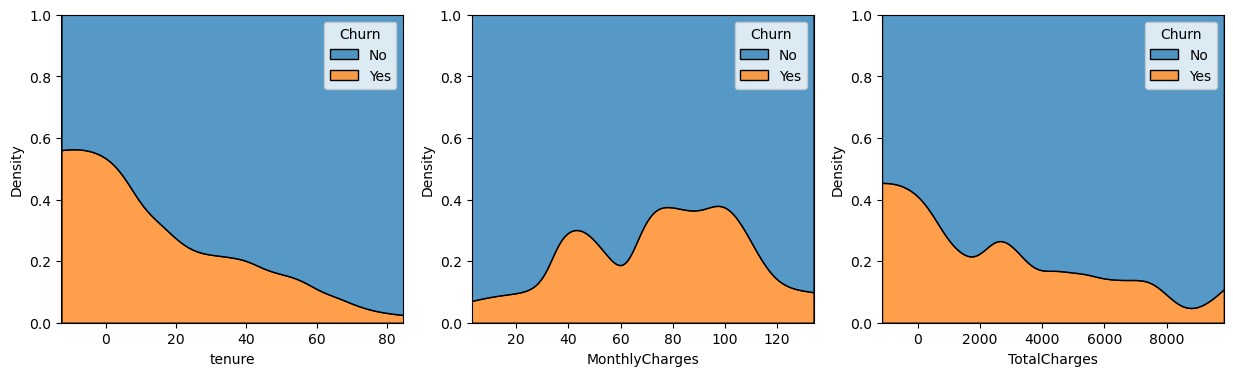

In [24]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

sns.kdeplot(data=df, x='tenure', hue='Churn', multiple='fill', ax=ax[0])
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', multiple='fill', ax=ax[1])
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', multiple='fill', ax=ax[2])

plt.show()

`Tenure` and `TotalCharges` clearly have a negative correlation with the probability of churn.

`MonthlyCharges` displays no clear trend.

# Preprocessing

In [34]:
df_one_hot = pd.get_dummies(df, drop_first=True)

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_one_hot)

df_scaled = pd.DataFrame(scaler.transform(df_one_hot), columns=df_one_hot.columns)

In [41]:
df_scaled.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
       'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_Yes'],
      dtype='object')

In [51]:
X = df_scaled[['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
       'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']]
y = df_scaled['Churn_Yes']

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.3)

# Oversampling

Becasue there is a class imbalance problem, we have to oversample one class.

In [85]:
smote = SMOTE()

X_re, y_re = smote.fit_resample(X, y)

X_re = pd.DataFrame(X_re, columns=X.columns)
y_re = pd.DataFrame({'Churn_yes': y_re})

print(y_re.loc[y_re['Churn_yes'] > 0.5].shape[0], 
    y_re.loc[y_re['Churn_yes'] < 0.5].shape[0], 
    y_re.shape[0])

y_re = y_re['Churn_yes']

3634 3634 7268


# Train Models

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [86]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression()
]

scoring = ['accuracy','precision', 'recall', 'f1']

results = pd.DataFrame(columns = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'])

for model in models:
  cv_results = cross_validate(model, X_re, y_re, scoring=scoring, cv=5, return_train_score=True)
  results.loc[model.__class__.__name__] = [cv_results['test_accuracy'].mean(),
                                           cv_results['test_precision'].mean(),
                                           cv_results['test_recall'].mean(),
                                           cv_results['test_f1'].mean()]

In [87]:
results

,test_accuracy,test_precision,test_recall,test_f1
DecisionTreeClassifier,0.797203,0.797285,0.796940,0.793050
RandomForestClassifier,0.856093,0.849058,0.866015,0.852986
AdaBoostClassifier,0.806283,0.783983,0.845917,0.811893
GradientBoostingClassifier,0.838208,0.824659,0.858864,0.835736
LogisticRegression,0.775317,0.754951,0.815633,0.783988


It looks like `RandomForestClassifier` has the best performance.

In [93]:
from sklearn.metrics import recall_score, confusion_matrix

In [103]:
for model in models:
    model.fit(X_re, y_re)
    y_pred = model.predict(X_val)
    print(model.__class__.__name__, recall_score(y_pred, y_val, average='macro'))

DecisionTreeClassifier 0.6601006727016732
RandomForestClassifier 0.7204817452898503
AdaBoostClassifier 0.7151920312295794
GradientBoostingClassifier 0.7209556169339466
LogisticRegression 0.7167088150289017


<Axes: >

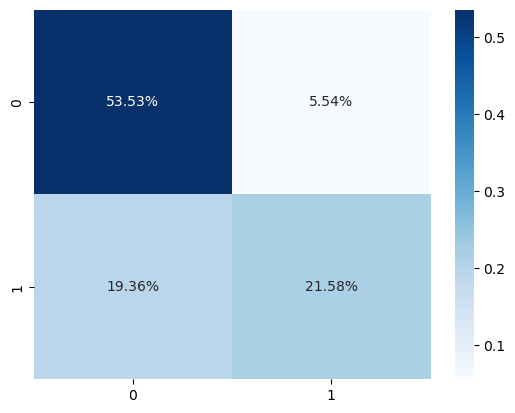

In [104]:
models[3].fit(X_re, y_re)
y_pred = model.predict(X_val)
cm = confusion_matrix(y_pred, y_val)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

<Axes: >

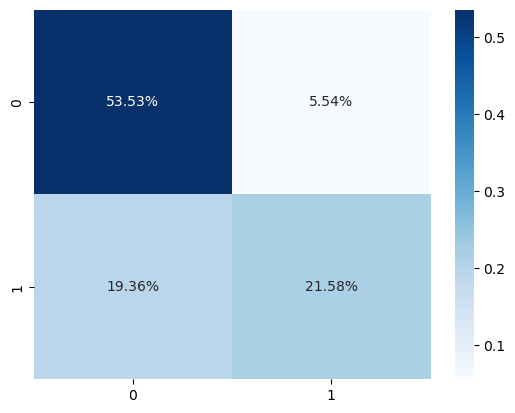

In [105]:
models[3].fit(X, y)
y_pred = model.predict(X_val)
cm = confusion_matrix(y_pred, y_val)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

Oversampling did not improve overall performance significantly.